In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, default_data_collator
from tqdm import tqdm
from kronfluence.utils.dataset import find_executable_batch_size

In [2]:
df = pd.read_csv('../../src/bio_if/data/plmbias/common_proteins_progen_esm_loglikelihood.csv')

In [3]:
df.head()

,Entry,Entry Name,primary_protein_name,all_protein_names,Gene Names,Organism,Length,genus_species,domain,kingdom,...,Description,sequence,progen2-medium_fp16_False_ll,progen2-base_fp16_False_ll,progen2-large_fp16_False_ll,progen2-xlarge_fp16_False_ll,progen2-BFD90_fp16_False_ll,ESM2_650M_pppl,ESM2_3B_pppl,ESM2_15B_pppl
0,O00541,PESC_HUMAN,Pescadillo homolog,Pescadillo homolog,PES1,Homo sapiens (Human),588,Homo sapiens,Eukaryota,Animalia,...,sp|O00541|PESC_HUMAN Pescadillo homolog OS=Hom...,MGGLEKKKYERGSATNYITRNKARKKLQLSLADFRRLCILKGIYPH...,-0.877656,-0.739062,-0.673376,-0.275376,-0.557462,-1.376413,-1.153031,-0.863481
1,O15229,KMO_HUMAN,Kynurenine 3-monooxygenase,Kynurenine 3-monooxygenase (EC 1.14.13.9) (Kyn...,KMO,Homo sapiens (Human),486,Homo sapiens,Eukaryota,Animalia,...,sp|O15229|KMO_HUMAN Kynurenine 3-monooxygenase...,MDSSVIQRKKVAVIGGGLVGSLQACFLAKRNFQIDVYEAREDTRVA...,-1.115627,-1.019284,-1.055469,-0.597102,-0.828649,-1.078029,-0.841189,-0.721648
2,O15371,EIF3D_HUMAN,Eukaryotic translation initiation factor 3 sub...,Eukaryotic translation initiation factor 3 sub...,EIF3D EIF3S7,Homo sapiens (Human),548,Homo sapiens,Eukaryota,Animalia,...,sp|O15371|EIF3D_HUMAN Eukaryotic translation i...,MAKFMTPVIQDNPSGWGPCAVPEQFRDMPYQPFSKGDRLGKVADWT...,-1.028079,-0.465545,-0.500757,-0.104518,-0.289271,-1.767279,-1.147200,-0.939404
3,O15372,EIF3H_HUMAN,Eukaryotic translation initiation factor 3 sub...,Eukaryotic translation initiation factor 3 sub...,EIF3H EIF3S3,Homo sapiens (Human),352,Homo sapiens,Eukaryota,Animalia,...,sp|O15372|EIF3H_HUMAN Eukaryotic translation i...,MASRKEGTGSTATSSSSTAGAAGKGKGKGGSGDSAVKQVQIDGLVV...,-1.272828,-1.144460,-0.878840,-0.297281,-0.522815,-1.453510,-1.361511,-1.337643
4,O43148,MCES_HUMAN,mRNA cap guanine-N7 methyltransferase,mRNA cap guanine-N7 methyltransferase (EC 2.1....,RNMT KIAA0398,Homo sapiens (Human),476,Homo sapiens,Eukaryota,Animalia,...,sp|O43148|MCES_HUMAN mRNA cap guanine-N7 methy...,MANSAKAEEYEKMSLEQAKASVNSETESSFNINENTTASGTGLSEK...,-1.465531,-1.197696,-1.246382,-0.836779,-1.065558,-1.062195,-0.843875,-0.803533


In [4]:
print(df.columns)

Index(['Entry', 'Entry Name', 'primary_protein_name', 'all_protein_names',
       'Gene Names', 'Organism', 'Length', 'genus_species', 'domain',
       'kingdom', 'phylum_division', 'class', 'genus', 'Description',
       'sequence', 'progen2-medium_fp16_False_ll',
       'progen2-base_fp16_False_ll', 'progen2-large_fp16_False_ll',
       'progen2-xlarge_fp16_False_ll', 'progen2-BFD90_fp16_False_ll',
       'ESM2_650M_pppl', 'ESM2_3B_pppl', 'ESM2_15B_pppl'],
      dtype='object')


(array([3.460e+02, 1.914e+03, 1.341e+03, 1.179e+03, 5.740e+02, 7.570e+02,
        4.310e+02, 4.150e+02, 1.350e+02, 1.050e+02, 8.500e+01, 4.500e+01,
        5.200e+01, 4.900e+01, 2.100e+01, 2.200e+01, 1.000e+01, 1.300e+01,
        1.300e+01, 9.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 7.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  13. ,   82.7,  152.4,  222.1,  291.8,  361.5,  431.2,  500.9,
         570.6,  640.3,  710. ,  779.7,  849.4,  919.1,  988.8, 1058.5,
        1128.2, 1197.9, 1267.6, 1337.3, 1407. , 1476.7, 1546.4, 1616.1,
        1685.8, 1755.5, 1825.2, 1894.9, 1964.6, 2034.3, 2104. , 2173.7,
        2243.4, 2313.1, 2382.8, 2452.5, 2522.2, 2591.9, 2661.6, 2731.3,
        2801. , 

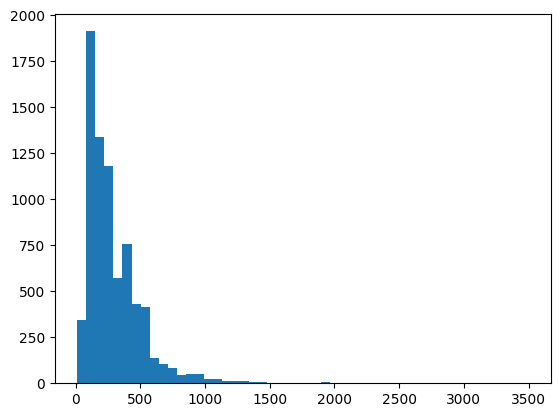

In [5]:
# make a histogram of sequence length
plt.hist(df['sequence'].apply(len), bins=50)

In [6]:
MODEL_NAME = 'facebook/esm2_t33_650M_UR50D'
DEVICE = 'cuda:0'

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, device_map=DEVICE)

In [8]:
# print all tokens of the tokenizer
CANONICAL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
tokenized_canonical_aas = tokenizer(CANONICAL_AAS)['input_ids'][1:-1]
assert not any([tokenized_canonical_aas[i] in tokenizer.all_special_ids for i in range(len(tokenized_canonical_aas))])
assert len(tokenized_canonical_aas) == len(CANONICAL_AAS)
print(tokenizer)
print(tokenizer.special_tokens_map)
print(tokenized_canonical_aas)

EsmTokenizer(name_or_path='facebook/esm2_t33_650M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
{'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token':

In [9]:
# ds = Dataset.from_dict({'seq': df['sequence'].tolist()})
# ds = ds.map(lambda x: tokenizer(x['seq'], padding='max_length', truncation=True, max_length=max(df['sequence'].apply(len))+2, return_tensors='pt'), batched=True)

In [21]:
# calculate true PPLs for ESM 650M
df['ESM2_650M_pppl_true'] = np.exp(-df['ESM2_650M_pppl'])

In [11]:
# get log likelihood of first sequence
seq = df['sequence'][0]
def get_log_likelihood(seq):
    model.eval()
    seqs = [seq]
    for i in range(len(seq)):
        masked_seq = seq[:i] + '<mask>' + seq[i+1:]
        seqs.append(masked_seq)
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=len(seq)+2, return_tensors='pt')
    assert torch.all(tokenized['input_ids'][:, -1] == tokenizer.eos_token_id)
    default_seq = {k: v[0:1] for k, v in tokenized.items()}
    tokenized = {k: v[1:] for k, v in tokenized.items()}

    BATCH_SIZE = 128
    total = 0
    dataset = Dataset.from_dict(tokenized)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=default_data_collator)
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        bs = batch['input_ids'].shape[0]
        for k, v in batch.items():
            batch[k] = v.to(DEVICE)
        
        with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
            outputs = model(**batch) # [batch_size, seq_len, num_tokens]
        individual_lls = torch.log_softmax(outputs.logits, dim=-1)[
            torch.arange(bs),
            torch.arange(1+i*BATCH_SIZE, 1+i*BATCH_SIZE+bs),
        ] # [batch_size, seq_len]
        total += sum(individual_lls[torch.arange(bs), default_seq['input_ids'][0, 1+i*BATCH_SIZE:1+i*BATCH_SIZE+bs]])
    return total.item() / len(seq) 

In [11]:
lls = []
for seq in tqdm(df['sequence'][:10]):
    lls.append(get_log_likelihood(seq))
    print(lls[-1])

 10%|█         | 1/10 [00:10<01:35, 10.58s/it]

-1.376540826291454


 20%|██        | 2/10 [00:16<01:01,  7.72s/it]

-1.0783214176633231


 30%|███       | 3/10 [00:24<00:55,  7.87s/it]

-1.7674027046147924


 40%|████      | 4/10 [00:27<00:35,  5.93s/it]

-1.45390831340443


 50%|█████     | 5/10 [00:33<00:29,  5.88s/it]

-1.0620464036444657


 60%|██████    | 6/10 [00:34<00:17,  4.30s/it]

-0.8018189786329801


 70%|███████   | 7/10 [01:05<00:39, 13.16s/it]

-0.7799362848801326


 80%|████████  | 8/10 [01:09<00:20, 10.04s/it]

-1.4322663994245632


 90%|█████████ | 9/10 [02:32<00:33, 33.03s/it]

-2.0510792896213035


100%|██████████| 10/10 [02:39<00:00, 15.98s/it]

-1.403676134474734


Text(0, 0.5, 'df log likelihood')

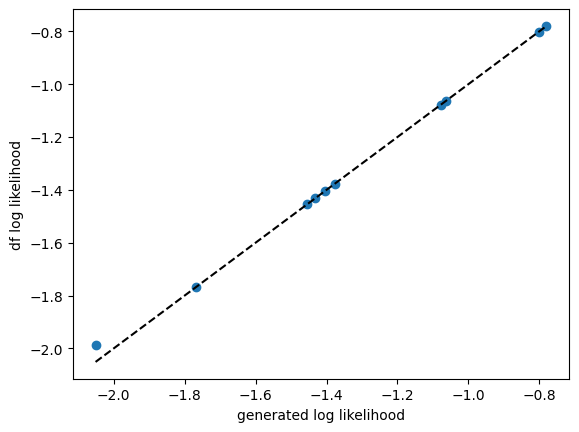

In [12]:
plt.plot(lls, df['ESM2_650M_pppl'][:len(lls)], 'o')
plt.plot([min(lls), max(lls)], [min(lls), max(lls)], 'k--')
plt.xlabel('generated log likelihood')
plt.ylabel('df log likelihood')

In [13]:
def get_one_shot_log_likelihood(seqs):
    model.eval()
    max_length = max([len(seq) for seq in seqs])
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    batch = {k: v.to(DEVICE) for k, v in tokenized.items()}
    label = batch['input_ids']
    label_special = torch.zeros_like(label, dtype=torch.bool)
    for special_id in tokenizer.all_special_ids:
        label_special |= label == special_id
    label = label.masked_fill(label_special, -100)

    with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
        outputs = model(**batch).logits.transpose(1, 2) # [batch_size, num_tokens, seq_len]

    individual_lls = torch.nn.functional.cross_entropy(outputs, label, reduction='none') # [batch_size, seq_len]
    return -(individual_lls.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)

In [14]:
olls = []
batch_size = 1
for i in tqdm(range(0, len(df['sequence']), batch_size)):
    seqs = df['sequence'][i:i+batch_size].tolist()
    olls.append(get_one_shot_log_likelihood(seqs))

100%|██████████| 7545/7545 [05:06<00:00, 24.62it/s]


In [16]:
olls = np.concatenate(olls)

In [17]:
df['esm650m_one_shot_log_likelihood'] = olls

In [17]:
def get_one_shot_pppl(seqs):
    model.eval()
    max_length = max([len(seq) for seq in seqs])
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    batch = {k: v.to(DEVICE) for k, v in tokenized.items()}
    label = batch['input_ids'] # [batch_size, seq_len]
    label_special = torch.zeros_like(label, dtype=torch.bool)
    for special_id in tokenizer.all_special_ids:
        label_special |= label == special_id
    # label = label.masked_fill(label_special, -1)

    with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
        outputs = model(**batch).logits # [batch_size, seq_len, num_tokens]

    individual_probs = torch.softmax(outputs, dim=-1).transpose(1, 2) # [batch_size, num_tokens, seq_len]
    individual_probs = individual_probs.gather(dim=1, index=label.unsqueeze(1)).squeeze(1) # [batch_size, seq_len]
    corrected_probs = 2 * individual_probs - 1
    corrected_probs = corrected_probs.masked_fill(label_special, 1)
    print(f"Percent of negative probs: {100 * (corrected_probs < 0).sum().item() / (~label_special).sum().item():.2f}%")
    return torch.pow(corrected_probs.prod(dim=-1), - 1 / (~label_special).sum(dim=-1)).numpy(force=True)
    # corrected_log_probs = torch.log((2*individual_probs - 1).clamp_min(1e-8))
    # corrected_log_probs = corrected_log_probs.masked_fill(label_special, 0)
    # return torch.exp(-(corrected_log_probs.sum(dim=-1) / (~label_special).sum(dim=-1))).numpy(force=True)

In [18]:
pppls = []
batch_size = 1
for i in tqdm(range(0, len(df['sequence']), batch_size)):
    seqs = df['sequence'][i:i+batch_size].tolist()
    pppls.append(get_one_shot_pppl(seqs))

  0%|          | 20/7545 [00:00<05:13, 24.01it/s]

100%|██████████| 7545/7545 [05:03<00:00, 24.87it/s]


In [19]:
df['esm650m_one_shot_pppl'] = np.concatenate(pppls)

Text(0, 0.5, 'Pseudo Perplexity')

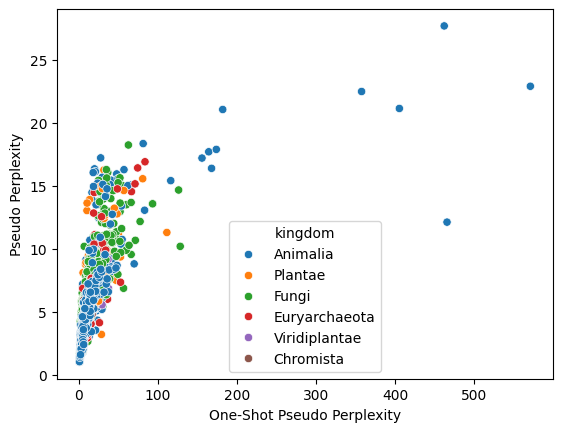

In [22]:
sns.scatterplot(x='esm650m_one_shot_pppl', y='ESM2_650M_pppl_true', data=df, hue='kingdom')
# plt.plot(olls, df['ESM2_650M_pppl'][:len(olls)], 'o')
# make line of best fit
# m, b = np.polyfit(np.array(olls), df['ESM2_650M_pppl'][:len(olls)], 1)
# plt.plot([min(olls), max(olls)], [m*min(olls)+b, m*max(olls)+b], 'k--')
plt.xlabel('One-Shot Pseudo Perplexity')
plt.ylabel('Pseudo Perplexity')

In [26]:
# compute r squared for both pearson and spearman
from scipy.stats import pearsonr, spearmanr
sp = spearmanr(olls, df['ESM2_650M_pppl'])
pe = pearsonr(olls, df['ESM2_650M_pppl'])
print(f'spearman r: {sp}')
print(f'pearson r: {pe}')

spearman r: SignificanceResult(statistic=0.9383633749428081, pvalue=0.0)
pearson r: PearsonRResult(statistic=0.9460311404442383, pvalue=0.0)
